<h1> Statistical Data Analysis (SDA) on Megaline Data </h1>
by Mikhail Karepov

The Megaline dataset offers a valuable resource for Statistical Data Analysis (SDA). This analysis will focus on examining customer behavior, identifying statistical patterns in call, text, and data usage, and evaluating key factors that affect revenue generation for the two prepaid plans, Surf and Ultimate. By employing various statistical techniques, the goal is to uncover significant trends, differences in plan usage, and correlations between customer location and revenue, ultimately aiding Megaline in making informed decisions regarding their advertising budget and overall business strategy.

## Which one is a better plan?

You work as an analyst for the telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.

You are going to carry out a preliminary analysis of the plans based on a relatively small client selection. You'll have the data on 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. Your job is to analyze the clients' behavior and determine which prepaid plan brings in more revenue.

### Initialization

In [1]:
# Loading all the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

plt.style.use('ggplot')

### Load data

In [2]:
# Load the data files into different DataFrames
megaline_calls = pd.read_csv('../datasets/megaline_calls.csv')
megaline_internet = pd.read_csv('../datasets/megaline_internet.csv')
megaline_messages = pd.read_csv('../datasets/megaline_messages.csv')
megaline_plans = pd.read_csv('../datasets/megaline_plans.csv')
megaline_users = pd.read_csv('../datasets/megaline_users.csv')

### Prepare the data

#### Plans

The `plans` table (data on the plans):

* **plan_name** — calling plan name
* **usd_monthly_fee** — monthly charge in US dollars
* **minutes_included** — monthly minute allowance
* **messages_included** — monthly text allowance
* **mb_per_month_included** — data volume allowance (in megabytes)
* **usd_per_minute** — price per minute after exceeding the package limits (e.g., if the package includes 100 minutes, the 101st minute will be charged)
* **usd_per_message** — price per text after exceeding the package limits
* **usd_per_gb** — price per extra gigabyte of data after exceeding the package limits (1 GB = 1024 megabytes)

In [3]:
# Print the general/summary information about the plans' DataFrame
print(megaline_plans.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 260.0+ bytes
None


In [4]:
# Print a sample of data for plans
display(megaline_plans.sample(2))

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [5]:
# Reviewer's code

display(megaline_calls.head(3))

megaline_calls.tail(3)

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48


,id,user_id,call_date,duration
137732,1499_201,1499,2018-09-21,8.12
137733,1499_202,1499,2018-10-10,0.37
137734,1499_203,1499,2018-12-29,13.86


**Data Inspection and Observations**

**Inspecting the `megaline_plans` dataset:**

- All columns have appropriate data types:
  - Integer (`int64`) for numerical fields like `minutes_included`, `messages_included`, and `mb_per_month_included`.
  - Float (`float64`) for monetary values such as `usd_per_gb`, `usd_per_message`, and `usd_per_minute`.
  - Object (`object`) for categorical data in the `plan_name` column.

- There are **no missing values** in the dataset, as indicated by the non-null counts.

In the sample data:
  - Higher-cost plan "ultimate" have lower overage fees compared to cheaper plan "surf".

##### Fix data

Since the dataset only contains two plans with no missing values and all columns have appropriate data types we'll keep datatset 'as is'

##### Enrich data

We'll calculate and compare the cost per minute, per message, and per GB for the two plans to assess which offers the better value.

In [6]:
# Calculate cost per minute, message, and GB
megaline_plans['cost_per_minute'] = megaline_plans['usd_monthly_pay'] / megaline_plans['minutes_included']
megaline_plans['cost_per_message'] = megaline_plans['usd_monthly_pay'] / megaline_plans['messages_included']
megaline_plans['cost_per_gb'] = megaline_plans['usd_monthly_pay'] / (megaline_plans['mb_per_month_included'] / 1024)

# Print cost comparison
display(megaline_plans[['plan_name', 'cost_per_minute', 'cost_per_message', 'cost_per_gb']])

,plan_name,cost_per_minute,cost_per_message,cost_per_gb
0,surf,0.040000,0.40,1.333333
1,ultimate,0.023333,0.07,2.333333


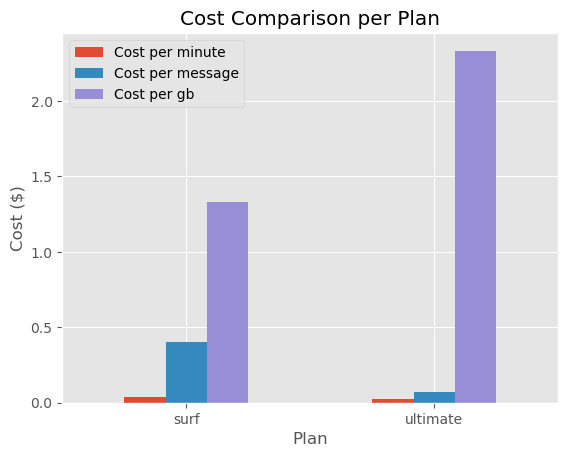

In [7]:
# Plot cost per unit for each plan
megaline_plans.set_index('plan_name')[['cost_per_minute', 'cost_per_message', 'cost_per_gb']].plot(kind='bar')
plt.title('Cost Comparison per Plan')
plt.ylabel('Cost ($)')
plt.xlabel('Plan')
plt.legend(['Cost per minute', 'Cost per message', 'Cost per gb'])
plt.xticks(rotation=0)
plt.show()

Conclusion:
- The `surf` plan has a **lower cost per GB** of data, making it more suitable for data-heavy users who prioritize lower data costs. However, it provides less GB per month overall, so users should consider the amount of data they need.
- The `ultimate` plan offers **lower costs per minute and per message**, which makes it ideal for users who communicate more via calls and messages.

#### Users

The `users` table (data on users):

* **user_id** — unique user identifier
* **first_name** — user's name
* **last_name** — user's last name
* **age — user's** age (years)
* **reg_date** — subscription date (dd, mm, yy)
* **churn_date** — the date the user stopped using the service (if the value is missing, the calling plan was being used when this database was extracted)
* **city** — user's city of residence
* **plan** — calling plan name

In [8]:
# Print the general/summary information about the users' DataFrame
print(megaline_users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None


In [9]:
# Print a sample of data for users
display(megaline_users.sample(10))
print()
print(f'Max user age:', megaline_users['age'].max())
print(f'Min user age:', megaline_users['age'].min())

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
206,1206,Angelic,Singleton,21,"Providence-Warwick, RI-MA MSA",2018-07-09,surf,NaN
334,1334,Donovan,Horton,34,"Seattle-Tacoma-Bellevue, WA MSA",2018-03-08,surf,NaN
155,1155,Claude,Hahn,19,"Miami-Fort Lauderdale-West Palm Beach, FL MSA",2018-02-21,ultimate,NaN
242,1242,Lashunda,Johns,37,"San Antonio-New Braunfels, TX MSA",2018-06-02,surf,NaN
128,1128,Lucius,Fernandez,41,"Knoxville, TN MSA",2018-01-25,ultimate,NaN
126,1126,Jermaine,Mcguire,68,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-06-02,ultimate,NaN
183,1183,Jermaine,Gallegos,71,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-07-20,surf,NaN
44,1044,Devora,Galloway,74,"Albuquerque, NM MSA",2018-08-30,surf,NaN
495,1495,Fidel,Sharpe,67,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-09-04,surf,NaN
344,1344,Hugo,Daugherty,70,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-12-25,surf,NaN



Max user age: 75
Min user age: 18


Data Inspection and Observations

Inspecting the `megaline_users` dataset:

- Data types:
  - Integer (`int64`) for numerical fields like `user_id` and `age`.
  - Object (`object`) for text fields such as `first_name`, `last_name`, `city`, `reg_date`, and `plan`.
  - `reg_date` and `churn_date` are stored as `object` and should be converted to `datetime` for proper date handling.

- Missing values:
   - There are **missing values** in the `churn_date` column, which makes sense as not all users have churned.
   - There are **no missing values** in the `age` column, indicating the data is complete for this field.

Next steps:
- **Convert `reg_date` and `churn_date` to `datetime`**:
  - This will allow proper manipulation and calculations involving dates.
  
- **Handle missing data**:
  - The `churn_date` column contains missing values (`NaN`). Investigate how many users have churned and consider treating `NaN` as users who have not churned.

- **Check for duplicates**:
  - Ensure there are no duplicate entries in the `user_id` field, as this should be a unique identifier.


##### Fix Data

In [10]:
# Convert reg_date and churn_date to datetime
megaline_users['reg_date'] = pd.to_datetime(megaline_users['reg_date'])
megaline_users['churn_date'] = pd.to_datetime(megaline_users['churn_date'])

print()
# Count users with and without churn dates
churned = megaline_users['churn_date'].notna().sum()
active = megaline_users['churn_date'].isna().sum()
print(f"Churned users: {churned}, Active users: {active}")

print()
# Check for duplicate user IDs
print(f"Number of duplicate IDs: {len(megaline_users[megaline_users.duplicated('user_id')])}")


Churned users: 34, Active users: 466

Number of duplicate IDs: 0


##### Enrich Data

In [11]:
# Calculate the duration of service.
# We are using '2018-12-31' instead of today's date, as the dataset only contains data up to '2018-12-31'.
megaline_users['service_duration'] = (megaline_users['churn_date'].fillna(pd.Timestamp('2018-12-31')) - megaline_users['reg_date']).dt.days

# Segment users into age groups, 18 y.o. included in the first bin
age_bins = [18, 30, 45, 60, 75, 150]
age_labels = ['18-30', '30-45', '45-60', '60-75', '75+']
megaline_users['age_group'] = pd.cut(megaline_users['age'], bins=age_bins, labels=age_labels, right=False)
print(megaline_users['age_group'].value_counts(dropna=False).sort_values(ascending=False)) 
print()
# Extract state MSA abbreviation by splitting after the last comma
megaline_users['msa'] = megaline_users['city'].str.split(',').str[1].str.replace(' MSA', '').str.strip()

display(megaline_users.sample(10))
print()
print(megaline_users.info())

age_group
45-60    127
60-75    125
18-30    120
30-45    118
75+       10
Name: count, dtype: int64



,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,service_duration,age_group,msa
165,1165,Nigel,Huber,20,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",2018-10-27,surf,NaT,65,18-30,PA-NJ-DE-MD
335,1335,Gail,Coleman,61,"Dallas-Fort Worth-Arlington, TX MSA",2018-06-02,surf,NaT,212,60-75,TX
491,1491,Terina,Jensen,22,"Grand Rapids-Kentwood, MI MSA",2018-04-27,surf,2018-09-18,144,18-30,MI
366,1366,Rod,Huff,62,"Cincinnati, OH-KY-IN MSA",2018-07-30,surf,NaT,154,60-75,OH-KY-IN
135,1135,Scotty,White,51,"Miami-Fort Lauderdale-West Palm Beach, FL MSA",2018-12-23,ultimate,NaT,8,45-60,FL
279,1279,Neal,Duke,27,"Baton Rouge, LA MSA",2018-02-05,ultimate,NaT,329,18-30,LA
50,1050,Jone,Owen,23,"Miami-Fort Lauderdale-West Palm Beach, FL MSA",2018-03-20,ultimate,2018-10-07,201,18-30,FL
270,1270,Anjelica,Chan,70,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",2018-09-18,ultimate,NaT,104,60-75,PA-NJ-DE-MD
408,1408,Alaine,Robertson,40,"Baltimore-Columbia-Towson, MD MSA",2018-01-11,surf,NaT,354,30-45,MD
160,1160,Steven,Morgan,44,"Portland-Vancouver-Hillsboro, OR-WA MSA",2018-02-05,surf,NaT,329,30-45,OR-WA



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   user_id           500 non-null    int64         
 1   first_name        500 non-null    object        
 2   last_name         500 non-null    object        
 3   age               500 non-null    int64         
 4   city              500 non-null    object        
 5   reg_date          500 non-null    datetime64[ns]
 6   plan              500 non-null    object        
 7   churn_date        34 non-null     datetime64[ns]
 8   service_duration  500 non-null    int64         
 9   age_group         500 non-null    category      
 10  msa               500 non-null    object        
dtypes: category(1), datetime64[ns](2), int64(3), object(5)
memory usage: 39.9+ KB
None


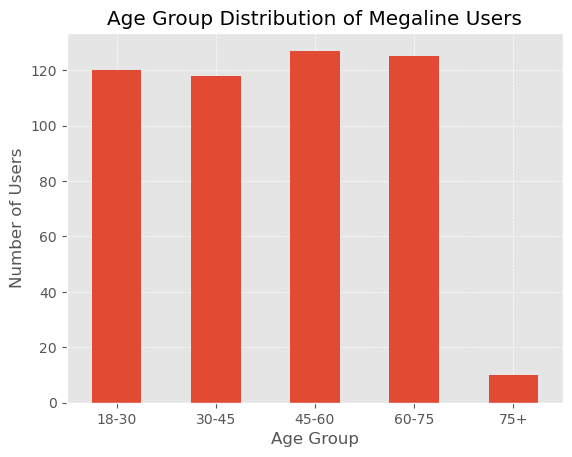

In [12]:
# Plot age group distribution
age_group_distribution = megaline_users['age_group'].value_counts().sort_index()
age_group_distribution.plot(kind='bar')

plt.title('Age Group Distribution of Megaline Users')
plt.xlabel('Age Group')
plt.ylabel('Number of Users')
plt.xticks(rotation=0)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

**Conclusions**:

- The largest age group is 45-60, followed by 60-75 and 18-30.
- The smallest age group is 75+, indicating that most users fall within the working-age population.

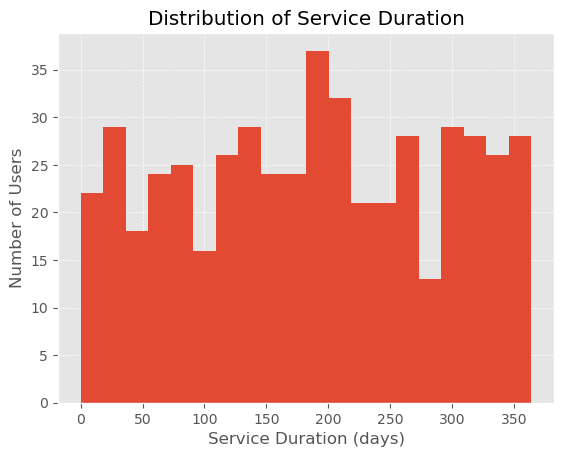

In [13]:
megaline_users['service_duration'].plot(kind='hist', bins=20)

plt.title('Distribution of Service Duration')
plt.xlabel('Service Duration (days)')
plt.ylabel('Number of Users')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

**Conclusions**:

- **Even Distribution**: The service duration is spread relatively evenly across the year, with a few peaks and troughs, but no strong clustering of users around any specific duration.
- **Peaks at Various Points**: There are noticeable peaks around 200 days. This might suggest some groups of users sign up at specific times of the year, possibly linked to marketing campaigns or promotions.

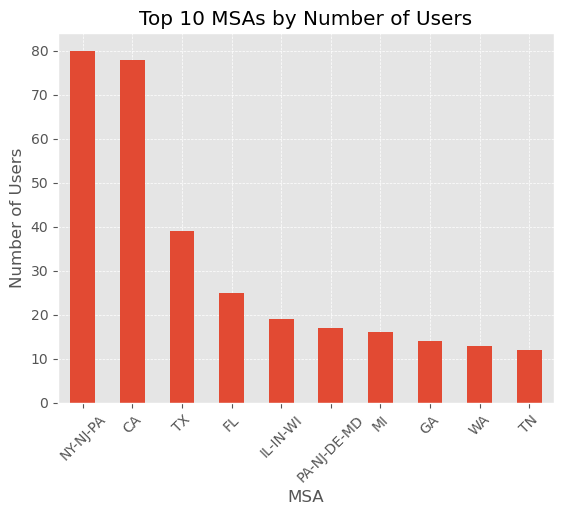

In [14]:
# Plot MSA distribution
msa_distribution = megaline_users['msa'].value_counts().head(10)
msa_distribution.plot(kind='bar')

plt.title('Top 10 MSAs by Number of Users')
plt.xlabel('MSA')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

**Conclusions**:

- The top MSAs for Megaline users include New York-Newark-Jersey City, California and Texas.

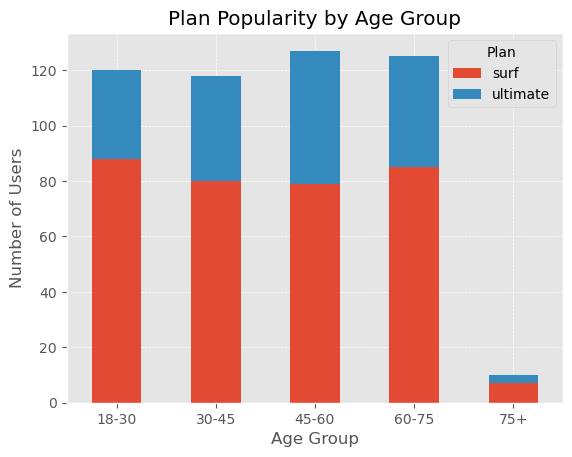

In [15]:
age_group_plan_distribution = megaline_users.groupby(['age_group', 'plan']).size().unstack()
age_group_plan_distribution.plot(kind='bar', stacked=True)

plt.title('Plan Popularity by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Users')
plt.xticks(rotation=0)
plt.legend(title='Plan')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

**Conclusions**:

- The Surf plan tends to be more popular across most age groups, but the Ultimate plan has a higher proportion in the 45-60 age group.
- This could suggest that middle-age users are more willing to pay for a premium service, whereas other users prefer a more affordable plan.

#### Calls

The `calls` table (data on calls):

* **id** — unique call identifier
* **call_date** — call date
* **duration** — call duration (in minutes)
* **user_id** — the identifier of the user making the call

In [16]:
# Print the general/summary information about the calls' DataFrame
print(megaline_calls.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB
None


In [17]:
# Print a sample of data for calls
display(megaline_calls.sample(10))

,id,user_id,call_date,duration
32584,1122_422,1122,2018-09-25,3.10
57163,1203_554,1203,2018-04-20,11.48
27430,1103_220,1103,2018-12-26,11.45
17664,1067_225,1067,2018-10-25,12.69
28469,1109_96,1109,2018-12-05,0.00
131414,1472_395,1472,2018-08-27,0.00
88533,1324_587,1324,2018-10-15,0.90
134764,1489_92,1489,2018-12-16,6.20
79987,1287_36,1287,2018-12-17,1.66
9775,1044_18,1044,2018-11-11,12.61


Data Inspection and Observations

Inspecting the `megaline_calls` dataset:

- Data types:
  - Integer (`int64`) for numerical field like `user_id`.
  - Float (`float64`) for numerical field like `duration`, which is correct for storing decimal values of call duration in minutes.
  - Object (`object`) for the unique `id` for each call.
  - `call_date` is stored as `object` and should be converted to `datetime` for proper date handling.

- Missing values:
  - There are **no missing values** in the dataset.
  
  
- Special observations:
  - Some calls have a `duration` of `0.00` minutes, indicating they were likely missed or unanswered calls.
  
  
  Next steps:
- **Convert `call_date` to `datetime`**:
  - This will allow proper manipulation and calculations involving dates.

- **Check for duplicates**:
  - Ensure there are no duplicate entries in the `id` field, as this should be a unique identifier.
  
- **Create a `missed_call` column**:
  - Flag calls with `0.00` `duration` as missed

##### Fix data

In [18]:
# Convert call_date to datetime
megaline_calls['call_date'] = pd.to_datetime(megaline_calls['call_date'])

# Create a missed_call column
megaline_calls['missed_call'] = megaline_calls['duration'] == 0.0

# Check for duplicate call IDs
print(f"Number of duplicate IDs: {len(megaline_calls[megaline_calls.duplicated('id')])}")

Number of duplicate IDs: 0


##### Enrich data

In [19]:
# Create a missed_call column
megaline_calls['missed_call'] = megaline_calls['duration'] == 0.0

# Create a month column to analyze patters by month
print(f'Max date:', megaline_calls['call_date'].max())
print(f'Min date:', megaline_calls['call_date'].min())

megaline_calls['month'] = megaline_calls['call_date'].dt.to_period('M')

# Create a DOW column to analyze patters by day of the week
megaline_calls['day_of_week'] = megaline_calls['call_date'].dt.day_name()


print()
print(megaline_calls.info())
print()
display(megaline_calls.sample(10))

Max date: 2018-12-31 00:00:00
Min date: 2018-01-15 00:00:00

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   id           137735 non-null  object        
 1   user_id      137735 non-null  int64         
 2   call_date    137735 non-null  datetime64[ns]
 3   duration     137735 non-null  float64       
 4   missed_call  137735 non-null  bool          
 5   month        137735 non-null  period[M]     
 6   day_of_week  137735 non-null  object        
dtypes: bool(1), datetime64[ns](1), float64(1), int64(1), object(2), period[M](1)
memory usage: 6.4+ MB
None



,id,user_id,call_date,duration,missed_call,month,day_of_week
49170,1177_207,1177,2018-12-18,5.55,False,2018-12,Tuesday
43057,1157_86,1157,2018-09-11,8.42,False,2018-09,Tuesday
34368,1127_209,1127,2018-07-11,0.00,True,2018-07,Wednesday
123029,1434_352,1434,2018-05-06,0.00,True,2018-05,Sunday
115399,1404_193,1404,2018-11-03,5.64,False,2018-11,Saturday
47838,1173_51,1173,2018-12-30,13.98,False,2018-12,Sunday
90532,1328_162,1328,2018-06-26,8.04,False,2018-06,Tuesday
6022,1029_186,1029,2018-11-16,0.97,False,2018-11,Friday
50726,1183_70,1183,2018-10-28,0.00,True,2018-10,Sunday
91017,1328_647,1328,2018-05-02,6.76,False,2018-05,Wednesday


#### Messages

The `messages` table (data on texts):

* **id** — unique text message identifier
* **message_date** — text message date
* **user_id** — the identifier of the user sending the text

In [20]:
# Print the general/summary information about the messages' DataFrame
print(megaline_messages.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB
None


In [21]:
# Print a sample of data for messages
display(megaline_messages.sample(10))

,id,user_id,message_date
43260,1285_92,1285,2018-11-22
43062,1283_1,1283,2018-12-13
59539,1379_16,1379,2018-12-18
53712,1340_238,1340,2018-09-22
22084,1132_1688,1132,2018-09-28
45176,1303_95,1303,2018-12-17
41465,1266_8,1266,2018-12-29
51533,1335_122,1335,2018-07-11
64972,1414_188,1414,2018-09-08
56758,1361_110,1361,2018-07-19


Data Inspection and Observations

Inspecting the `megaline_messages` dataset:

- Data types:
  - Integer (`int64`) for numerical field like `user_id`.
  - Object (`object`) for the unique `id` for each message.
  - `message_date` is stored as `object` and should be converted to `datetime` for proper date handling.

- Missing values:
  - There are **no missing values** in the dataset.
  
  
  Next steps:
- **Convert `message_date` to `datetime`**:
  - This will allow proper manipulation and calculations involving dates.

- **Check for duplicates**:
  - Ensure there are no duplicate entries in the `id` field, as this should be a unique identifier.

##### Fix data

In [22]:
# Convert message_date to datetime
megaline_messages['message_date'] = pd.to_datetime(megaline_messages['message_date'])

# Check for duplicate message IDs
print(f"Number of duplicate IDs: {len(megaline_messages[megaline_messages.duplicated('id')])}")

Number of duplicate IDs: 0


##### Enrich data

In [23]:
# Create a month column to analyze patters by month

megaline_messages['month'] = megaline_messages['message_date'].dt.to_period('M')

# Create a DOW column to analyze patters by day of the week

megaline_messages['day_of_week'] = megaline_messages['message_date'].dt.day_name()

print()
print(megaline_messages.info())
print()
display(megaline_messages.sample(10))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
 3   month         76051 non-null  period[M]     
 4   day_of_week   76051 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2), period[M](1)
memory usage: 2.9+ MB
None



,id,user_id,message_date,month,day_of_week
70664,1460_146,1460,2018-07-16,2018-07,Monday
23373,1142_15,1142,2018-12-11,2018-12,Tuesday
21806,1132_1298,1132,2018-11-21,2018-11,Wednesday
14851,1100_173,1100,2018-08-15,2018-08,Wednesday
26081,1159_84,1159,2018-12-02,2018-12,Sunday
3061,1033_74,1033,2018-12-24,2018-12,Monday
42654,1280_160,1280,2018-10-29,2018-10,Monday
48145,1324_876,1324,2018-12-02,2018-12,Sunday
32912,1204_107,1204,2018-12-03,2018-12,Monday
63468,1405_132,1405,2018-12-14,2018-12,Friday


#### Internet

The `internet` table (data on web sessions):

* **id** — unique session identifier
* **mb_used** — the volume of data spent during the session (in megabytes)
* **session_date** — web session date
* **user_id** — user identifier

In [24]:
# Print the general/summary information about the internet DataFrame
print(megaline_internet.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB
None


In [25]:
# Print a sample of data for the internet traffic
display(megaline_internet.sample(10))

,id,user_id,session_date,mb_used
50878,1227_40,1227,2018-12-24,555.30
78246,1365_12,1365,2018-11-02,1022.60
86081,1400_215,1400,2018-10-15,55.68
93280,1435_46,1435,2018-09-23,0.00
22348,1101_240,1101,2018-09-10,230.79
6838,1039_113,1039,2018-11-11,162.34
78838,1367_510,1367,2018-12-15,128.48
20440,1095_90,1095,2018-06-20,394.48
874,1004_571,1004,2018-11-18,619.04
2914,1016_126,1016,2018-11-05,249.43


Data Inspection and Observations

Inspecting the `megaline_internet` dataset:

- Data types:
  - Integer (`int64`) for numerical field like `user_id`.
  - Float (`float64`) for numerical field like `mb_used`, which is correct for storing decimal values of data used in megabytes.
  - Object (`object`) for the unique `id` for each session.
  - `session_date` is stored as `object` and should be converted to `datetime` for proper date handling.

- Missing values:
  - There are **no missing values** in the dataset.
  
  
- Special observations:
  - Some sessions have a `mb_used` of `0.00` megabytes, indicating that there may have been inactive or unsuccessful sessions.
  
  
  Next steps:
- **Convert `session_date` to `datetime`**:
  - This will allow proper manipulation and calculations involving dates.

- **Check for duplicates**:
  - Ensure there are no duplicate entries in the `id` field, as this should be a unique identifier.
  
- **Create a `zero_session` column**:
  - Flag sessions with `0.00` `mb_used` as empty

##### Fix data

In [26]:
# Convert message_date to datetime
megaline_internet['session_date'] = pd.to_datetime(megaline_internet['session_date'])

# Check for duplicate message IDs
print(f"Number of duplicate IDs: {len(megaline_internet[megaline_internet.duplicated('id')])}")

Number of duplicate IDs: 0


##### Enrich data

In [27]:
# Create a zero_session column
megaline_internet['zero_session'] = megaline_internet['mb_used'] == 0.00

# Create a month column to analyze patters by month

megaline_internet['month'] = megaline_internet['session_date'].dt.to_period('M')

# Create a DOW column to analyze patters by day of the week

megaline_internet['day_of_week'] = megaline_internet['session_date'].dt.day_name()

print()
print(megaline_internet.info())
print()
display(megaline_internet.sample(10))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
 4   zero_session  104825 non-null  bool          
 5   month         104825 non-null  period[M]     
 6   day_of_week   104825 non-null  object        
dtypes: bool(1), datetime64[ns](1), float64(1), int64(1), object(2), period[M](1)
memory usage: 4.9+ MB
None



,id,user_id,session_date,mb_used,zero_session,month,day_of_week
23570,1109_148,1109,2018-10-21,282.15,False,2018-10,Sunday
103354,1494_236,1494,2018-09-11,41.66,False,2018-09,Tuesday
2512,1011_252,1011,2018-07-23,116.18,False,2018-07,Monday
16430,1073_369,1073,2018-05-07,395.09,False,2018-05,Monday
99144,1467_281,1467,2018-11-05,176.98,False,2018-11,Monday
57756,1261_212,1261,2018-06-02,500.66,False,2018-06,Saturday
37937,1171_308,1171,2018-04-14,0.00,True,2018-04,Saturday
79097,1368_286,1368,2018-05-26,404.22,False,2018-05,Saturday
83658,1390_213,1390,2018-12-21,131.28,False,2018-12,Friday
70544,1329_171,1329,2018-09-29,453.14,False,2018-09,Saturday


### Study plan conditions

In [28]:
# Print out the plan conditions and make sure they are clear for you
print(megaline_plans)
print()
display(megaline_plans.set_index('plan_name').transpose().round(2))

   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  \
0               20          10             0.03            0.03      surf   
1               70           7             0.01            0.01  ultimate   

   cost_per_minute  cost_per_message  cost_per_gb  
0         0.040000              0.40     1.333333  
1         0.023333              0.07     2.333333  



plan_name,surf,ultimate
messages_included,50.00,1000.00
mb_per_month_included,15360.00,30720.00
minutes_included,500.00,3000.00
usd_monthly_pay,20.00,70.00
usd_per_gb,10.00,7.00
usd_per_message,0.03,0.01
usd_per_minute,0.03,0.01
cost_per_minute,0.04,0.02
cost_per_message,0.40,0.07
cost_per_gb,1.33,2.33


### Aggregate data per user

In [29]:
# Calculate the number of calls made by each user per month. Save the result.
calls_per_user_per_month = megaline_calls.groupby(['user_id', 'month'])['id'].count().reset_index(name='calls_made')
display(calls_per_user_per_month)

,user_id,month,calls_made
0,1000,2018-12,16
1,1001,2018-08,27
2,1001,2018-09,49
3,1001,2018-10,65
4,1001,2018-11,64
...,...,...,...
2253,1498,2018-12,39
2254,1499,2018-09,41
2255,1499,2018-10,53
2256,1499,2018-11,45


In [30]:
# Calculate the amount of minutes spent by each user per month. Save the result.
megaline_calls['duration'] = np.ceil(megaline_calls['duration'])
calls_and_minutes = megaline_calls.groupby(['user_id', 'month'])['duration'].agg(calls_made='count',total_minutes_spent='sum').reset_index()
display(calls_and_minutes)

,user_id,month,calls_made,total_minutes_spent
0,1000,2018-12,16,124.0
1,1001,2018-08,27,182.0
2,1001,2018-09,49,315.0
3,1001,2018-10,65,393.0
4,1001,2018-11,64,426.0
...,...,...,...,...
2253,1498,2018-12,39,339.0
2254,1499,2018-09,41,346.0
2255,1499,2018-10,53,385.0
2256,1499,2018-11,45,308.0


In [31]:
# Calculate the number of messages sent by each user per month. Save the result.
messages_per_user_per_month = megaline_messages.groupby(['user_id', 'month'])['id'].count().reset_index(name='messages_sent')
display(messages_per_user_per_month)


,user_id,month,messages_sent
0,1000,2018-12,11
1,1001,2018-08,30
2,1001,2018-09,44
3,1001,2018-10,53
4,1001,2018-11,36
...,...,...,...
1801,1496,2018-09,21
1802,1496,2018-10,18
1803,1496,2018-11,13
1804,1496,2018-12,11


In [32]:
# Calculate the volume of internet traffic used by each user per month. Save the result.
internet_per_user_per_month = megaline_internet.groupby(['user_id', 'month'])['mb_used'].sum().reset_index(name='total_mb_used')
display(internet_per_user_per_month)


,user_id,month,total_mb_used
0,1000,2018-12,1901.47
1,1001,2018-08,6919.15
2,1001,2018-09,13314.82
3,1001,2018-10,22330.49
4,1001,2018-11,18504.30
...,...,...,...
2272,1498,2018-12,23137.69
2273,1499,2018-09,12984.76
2274,1499,2018-10,19492.43
2275,1499,2018-11,16813.83


In [33]:
# Merge the data for calls, minutes, messages, internet based on user_id and month
calls_minutes_messages = calls_and_minutes.merge(messages_per_user_per_month, on=['user_id', 'month'], how='outer')
complete_data = calls_minutes_messages.merge(internet_per_user_per_month, on=['user_id', 'month'], how='outer')

# Fill missing values with 0 (in case there was no data for particular users in merged datatframe)
complete_data.fillna(0, inplace=True)

display(complete_data)


,user_id,month,calls_made,total_minutes_spent,messages_sent,total_mb_used
0,1000,2018-12,16.0,124.0,11.0,1901.47
1,1001,2018-08,27.0,182.0,30.0,6919.15
2,1001,2018-09,49.0,315.0,44.0,13314.82
3,1001,2018-10,65.0,393.0,53.0,22330.49
4,1001,2018-11,64.0,426.0,36.0,18504.30
...,...,...,...,...,...,...
2288,1349,2018-12,0.0,0.0,61.0,13039.91
2289,1361,2018-05,0.0,0.0,2.0,1519.69
2290,1482,2018-10,0.0,0.0,2.0,0.00
2291,1108,2018-12,0.0,0.0,0.0,233.17


In [34]:
# Add the plan information

complete_data_with_plan = complete_data.merge(megaline_users[['user_id', 'plan', 'msa']], on='user_id', how='left')
final_data = complete_data_with_plan.merge(megaline_plans, left_on='plan', right_on='plan_name', how='left')

final_data.drop(columns=['plan_name'], inplace=True)

display(final_data)
print(final_data.info())

,user_id,month,calls_made,total_minutes_spent,messages_sent,total_mb_used,plan,msa,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,cost_per_minute,cost_per_message,cost_per_gb
0,1000,2018-12,16.0,124.0,11.0,1901.47,ultimate,GA,1000,30720,3000,70,7,0.01,0.01,0.023333,0.07,2.333333
1,1001,2018-08,27.0,182.0,30.0,6919.15,surf,WA,50,15360,500,20,10,0.03,0.03,0.040000,0.40,1.333333
2,1001,2018-09,49.0,315.0,44.0,13314.82,surf,WA,50,15360,500,20,10,0.03,0.03,0.040000,0.40,1.333333
3,1001,2018-10,65.0,393.0,53.0,22330.49,surf,WA,50,15360,500,20,10,0.03,0.03,0.040000,0.40,1.333333
4,1001,2018-11,64.0,426.0,36.0,18504.30,surf,WA,50,15360,500,20,10,0.03,0.03,0.040000,0.40,1.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1349,2018-12,0.0,0.0,61.0,13039.91,surf,MA-NH,50,15360,500,20,10,0.03,0.03,0.040000,0.40,1.333333
2289,1361,2018-05,0.0,0.0,2.0,1519.69,surf,AL,50,15360,500,20,10,0.03,0.03,0.040000,0.40,1.333333
2290,1482,2018-10,0.0,0.0,2.0,0.00,ultimate,NY-NJ-PA,1000,30720,3000,70,7,0.01,0.01,0.023333,0.07,2.333333
2291,1108,2018-12,0.0,0.0,0.0,233.17,ultimate,UT,1000,30720,3000,70,7,0.01,0.01,0.023333,0.07,2.333333


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2293 entries, 0 to 2292
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype    
---  ------                 --------------  -----    
 0   user_id                2293 non-null   int64    
 1   month                  2293 non-null   period[M]
 2   calls_made             2293 non-null   float64  
 3   total_minutes_spent    2293 non-null   float64  
 4   messages_sent          2293 non-null   float64  
 5   total_mb_used          2293 non-null   float64  
 6   plan                   2293 non-null   object   
 7   msa                    2293 non-null   object   
 8   messages_included      2293 non-null   int64    
 9   mb_per_month_included  2293 non-null   int64    
 10  minutes_included       2293 non-null   int64    
 11  usd_monthly_pay        2293 non-null   int64    
 12  usd_per_gb             2293 non-null   int64    
 13  usd_per_message        2293 non-null   float64  
 14  usd_per_minute         2

,user_id,month,calls_made,total_minutes_spent,messages_sent,total_mb_used,plan,msa,messages_included,mb_per_month_included,...,cost_per_message,cost_per_gb,extra_minutes,extra_messages,extra_data_gb,extra_minutes_charge,extra_messages_charge,extra_data_charge,total_extra_charge,monthly_revenue
0,1000,2018-12,16.0,124.0,11.0,1901.47,ultimate,GA,1000,30720,...,0.07,2.333333,0.0,0.0,0.0,0.0,0.00,0.0,0.00,70.00
1,1001,2018-08,27.0,182.0,30.0,6919.15,surf,WA,50,15360,...,0.40,1.333333,0.0,0.0,0.0,0.0,0.00,0.0,0.00,20.00
2,1001,2018-09,49.0,315.0,44.0,13314.82,surf,WA,50,15360,...,0.40,1.333333,0.0,0.0,0.0,0.0,0.00,0.0,0.00,20.00
3,1001,2018-10,65.0,393.0,53.0,22330.49,surf,WA,50,15360,...,0.40,1.333333,0.0,3.0,7.0,0.0,0.09,70.0,70.09,90.09
4,1001,2018-11,64.0,426.0,36.0,18504.30,surf,WA,50,15360,...,0.40,1.333333,0.0,0.0,4.0,0.0,0.00,40.0,40.00,60.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1349,2018-12,0.0,0.0,61.0,13039.91,surf,MA-NH,50,15360,...,0.40,1.333333,0.0,11.0,0.0,0.0,0.33,0.0,0.33,20.33
2289,1361,2018-05,0.0,0.0,2.0,1519.69,surf,AL,50,15360,...,0.40,1.333333,0.0,0.0,0.0,0.0,0.00,0.0,0.00,20.00
2290,1482,2018-10,0.0,0.0,2.0,0.00,ultimate,NY-NJ-PA,1000,30720,...,0.07,2.333333,0.0,0.0,0.0,0.0,0.00,0.0,0.00,70.00
2291,1108,2018-12,0.0,0.0,0.0,233.17,ultimate,UT,1000,30720,...,0.07,2.333333,0.0,0.0,0.0,0.0,0.00,0.0,0.00,70.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2293 entries, 0 to 2292
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype    
---  ------                 --------------  -----    
 0   user_id                2293 non-null   int64    
 1   month                  2293 non-null   period[M]
 2   calls_made             2293 non-null   float64  
 3   total_minutes_spent    2293 non-null   float64  
 4   messages_sent          2293 non-null   float64  
 5   total_mb_used          2293 non-null   float64  
 6   plan                   2293 non-null   object   
 7   msa                    2293 non-null   object   
 8   messages_included      2293 non-null   int64    
 9   mb_per_month_included  2293 non-null   int64    
 10  minutes_included       2293 non-null   int64    
 11  usd_monthly_pay        2293 non-null   int64    
 12  usd_per_gb             2293 non-null   int64    
 13  usd_per_message        2293 non-null   float64  
 14  usd_per_minute         2

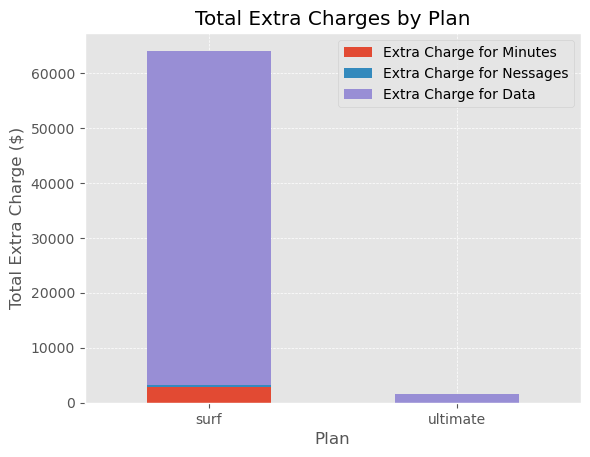

In [35]:
# Calculate the monthly revenue for each user
# Step 1: Calculate extra usage
final_data['extra_minutes'] = (final_data['total_minutes_spent'] - final_data['minutes_included']).clip(lower=0)
final_data['extra_messages'] = (final_data['messages_sent'] - final_data['messages_included']).clip(lower=0)
final_data['extra_data_gb'] = np.ceil(((final_data['total_mb_used'] - final_data['mb_per_month_included']) / 1024).clip(lower=0))

# Step 2: Calculate extra charges
final_data['extra_minutes_charge'] = final_data['extra_minutes'] * final_data['usd_per_minute']
final_data['extra_messages_charge'] = final_data['extra_messages'] * final_data['usd_per_message']
final_data['extra_data_charge'] = final_data['extra_data_gb'] * final_data['usd_per_gb']

# Step 3: Calculate total extra charge
final_data['total_extra_charge'] = (
    final_data['extra_minutes_charge'] + 
    final_data['extra_messages_charge'] + 
    final_data['extra_data_charge']
)

# Step 4: Calculate total revenue
final_data['monthly_revenue'] = (
    final_data['usd_monthly_pay'] + 
    final_data['total_extra_charge'] 
)

# Step 5: Display the resulting revenue data
display(final_data)
print(final_data.info())

extra_charge_by_plan = final_data.groupby('plan')[['extra_minutes_charge', 'extra_messages_charge', 'extra_data_charge']].sum().reset_index()
extra_charge_by_plan.plot(kind='bar', x='plan', stacked=True)

plt.title('Total Extra Charges by Plan')
plt.xlabel('Plan')
plt.ylabel('Total Extra Charge ($)')
plt.legend(['Extra Charge for Minutes', 'Extra Charge for Nessages', 'Extra Charge for Data'])
plt.xticks(rotation=0)
plt.grid(True, linestyle='--', linewidth=0.5)

plt.show()

**Conclusions**:

- Users on the Ultimate plan have fewer instances of extra charges due to the higher included limits for minutes, messages, and data, leading to more predictable monthly revenues.
- Surf plan users are more likely to incur extra charges due to lower included limits, which increases revenue variability based on usage.
- Users who frequently exceed their plan limits contribute more to monthly revenue through extra charges. This behavior is more noticeable among Surf plan users, as shown by additional revenue from data, messages, and calls.

### Study user behaviour

#### Calls

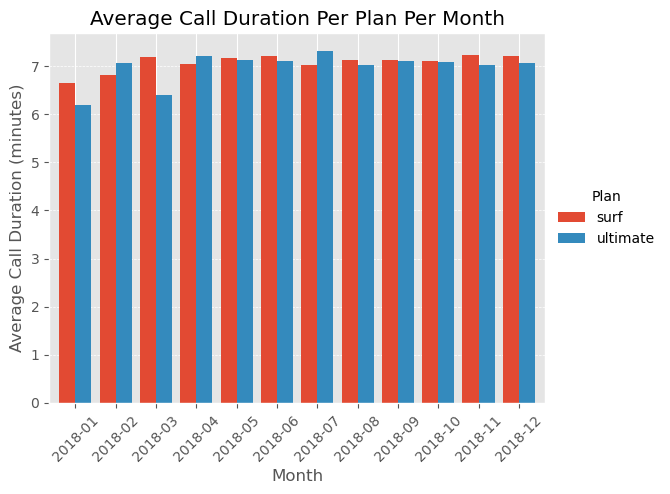

In [36]:
# Compare average duration of calls per each plan per each distinct month. Plot a bar plat to visualize it.
final_data['avg_call_duration'] = final_data['total_minutes_spent'] / final_data['calls_made']

avg_call_duration_per_plan = final_data.groupby(['plan', 'month'])['avg_call_duration'].mean().reset_index()

avg_call_duration_per_plan_pivot = avg_call_duration_per_plan.pivot(index='month', 
                                                                    columns='plan', 
                                                                    values='avg_call_duration')
avg_call_duration_per_plan_pivot.plot(kind='bar', width=0.8)


plt.title('Average Call Duration Per Plan Per Month')
plt.xlabel('Month')
plt.ylabel('Average Call Duration (minutes)')

plt.xticks(rotation=45)

plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

plt.legend(title='Plan', loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

plt.show()

Conclusions:
1.	**Stable Call Durations**: The average call duration remains consistent throughout the year, ranging from 5 to 7 minutes.
2.	**Similar Across Plans**: Both **Surf** and **Ultimate** plans show similar average call durations with minimal variation.
3.	**No Significant Trends**: There is no clear upward or downward trend in call durations for either plan across the months.

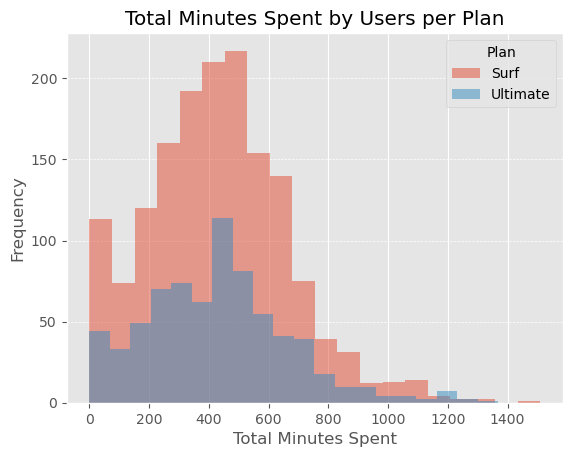

In [37]:
# Compare the number of minutes users of each plan require each month. Plot a histogram.
final_data[final_data['plan'] == 'surf']['total_minutes_spent'].plot(kind='hist', 
                                                                     bins=20, 
                                                                     alpha=0.5, 
                                                                     label='Surf'
                                                                    )
final_data[final_data['plan'] == 'ultimate']['total_minutes_spent'].plot(kind='hist', 
                                                                         bins=20, 
                                                                         alpha=0.5, 
                                                                         label='Ultimate'
                                                                        )

plt.title('Total Minutes Spent by Users per Plan')
plt.xlabel('Total Minutes Spent')
plt.ylabel('Frequency')


plt.legend(title='Plan')

plt.grid(True, axis='y', linestyle='--', linewidth=0.5)

plt.show()

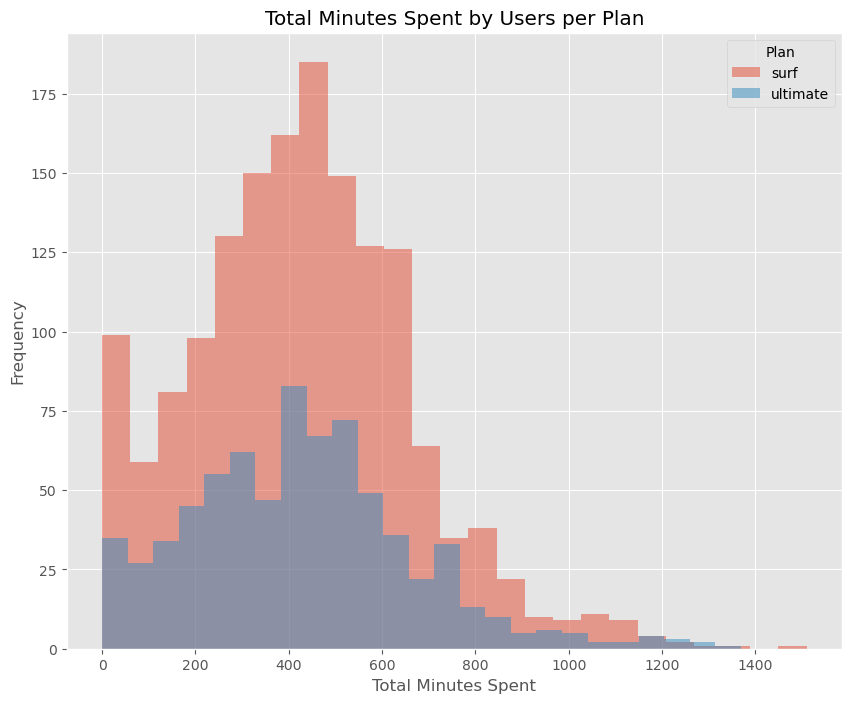

In [38]:
plt.style.use('ggplot')



final_data.groupby('plan')['total_minutes_spent'].plot.hist(alpha=0.5, legend=True, bins=25, figsize=(10,8))

plt.legend(['Surf', 'Ultimate'])
plt.title('Total Minutes Spent by Users per Plan')
plt.xlabel('Total Minutes Spent')
plt.ylabel('Frequency')

plt.legend(title='Plan')

plt.show()

Conclusions:
1.	**Similar Usage Patterns**: The distributions of total minutes spent per user for both the **Surf** and **Ultimate** plans are very similar. The peak for both plans is around 400 minutes, indicating that most users in both plans tend to spend roughly the same amount of total minutes.
2.	**Slightly Higher Peak for Ultimate**: The **Ultimate** plan shows a slightly higher peak around 400 minutes, suggesting that users on this plan might have a slightly higher likelihood of spending this amount of time.
3.	**Similar Long-Tail Behavior**: Both plans shows similar long-tail behavior, with a small number of users spending significantly more time (over 1000 minutes), but this is rare for both plans.

In [39]:
# Calculate the mean and the variance of the monthly call duration
call_duration_mean_var = final_data.groupby(['plan', 'month'])['total_minutes_spent'].agg(['mean', 'var', 'std']).reset_index()
display(call_duration_mean_var)
print()
display(final_data.groupby(['plan'])['total_minutes_spent'].agg(['mean', 'var', 'std']).reset_index())

,plan,month,mean,var,std
0,surf,2018-01,203.000000,15842.000000,125.865007
1,surf,2018-02,297.000000,52226.500000,228.531179
2,surf,2018-03,330.000000,35809.363636,189.233622
3,surf,2018-04,351.540000,50866.743265,225.536567
4,surf,2018-05,399.584416,59754.219754,244.446763
5,surf,2018-06,431.298969,45592.628436,213.524304
6,surf,2018-07,449.983471,61005.099725,246.992105
7,surf,2018-08,410.111111,54344.645963,233.119381
8,surf,2018-09,414.226804,46595.958656,215.860971
9,surf,2018-10,429.729958,52278.664056,228.645280


,plan,mean,var,std
0,surf,428.749523,54968.279461,234.453150
1,ultimate,430.450000,57844.464812,240.508762


In [40]:
# Stats with grouping by month
call_duration_mean_var = final_data.groupby(['plan', 'month'])['total_minutes_spent'].agg(['mean', 'var', 'std']).reset_index()
display(call_duration_mean_var)
print()
# Stats without grouping by month
display(final_data.groupby(['plan'])['total_minutes_spent'].agg(['mean', 'var', 'std']).reset_index())

,plan,month,mean,var,std
0,surf,2018-01,203.000000,15842.000000,125.865007
1,surf,2018-02,297.000000,52226.500000,228.531179
2,surf,2018-03,330.000000,35809.363636,189.233622
3,surf,2018-04,351.540000,50866.743265,225.536567
4,surf,2018-05,399.584416,59754.219754,244.446763
5,surf,2018-06,431.298969,45592.628436,213.524304
6,surf,2018-07,449.983471,61005.099725,246.992105
7,surf,2018-08,410.111111,54344.645963,233.119381
8,surf,2018-09,414.226804,46595.958656,215.860971
9,surf,2018-10,429.729958,52278.664056,228.645280


,plan,mean,var,std
0,surf,428.749523,54968.279461,234.453150
1,ultimate,430.450000,57844.464812,240.508762


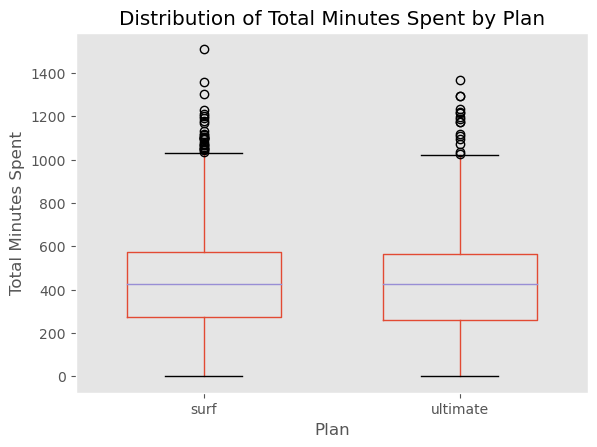

In [41]:
# Plot a boxplot to visualize the distribution of the monthly call duration

final_data.boxplot(column='total_minutes_spent', by='plan', grid=False, widths=0.6)


plt.title('Distribution of Total Minutes Spent by Plan')
plt.xlabel('Plan')
plt.suptitle('')
plt.ylabel('Total Minutes Spent')

plt.show()

Conclusions:
1.	**Similar Medians**: Both Surf and Ultimate plans have similar median call durations, around 400 minutes.
2.	**More Outliers in Surf**: The Surf plan has more outliers, indicating a few users spend significantly more time on calls.

Overall conclusions:
1.	**Similar Average Usage**: Both plans have similar average call durations.
2.	**More Variability in Surf**: Surf users show more variability with some users making very long calls.
3.	**Ultimate is More Consistent**: Ultimate users have more consistent calling behavior with fewer outliers.

#### Messages

,plan,month,messages_sent
0,surf,2018-01,10.500000
1,surf,2018-02,12.000000
2,surf,2018-03,15.260870
3,surf,2018-04,17.400000
4,surf,2018-05,24.012987
5,surf,2018-06,25.298969
6,surf,2018-07,27.033058
7,surf,2018-08,28.777778
8,surf,2018-09,30.762887
9,surf,2018-10,33.839662


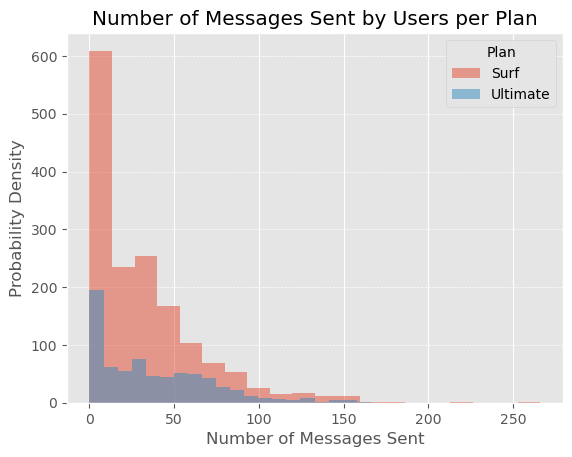

In [42]:
# Compare the number of messages users of each plan tend to send each month
messages_per_plan_per_month = final_data.groupby(['plan', 'month'])['messages_sent'].mean().reset_index()
display(messages_per_plan_per_month)

final_data[final_data['plan'] == 'surf']['messages_sent'].plot(kind='hist', 
                                                               bins=20, 
                                                               alpha=0.5, 
                                                               label='Surf')

final_data[final_data['plan'] == 'ultimate']['messages_sent'].plot(kind='hist', 
                                                                   bins=20, 
                                                                   alpha=0.5, 
                                                                   label='Ultimate')

plt.title('Number of Messages Sent by Users per Plan')
plt.xlabel('Number of Messages Sent')
plt.ylabel('Probability Density')

plt.legend(title='Plan')
plt.grid(True, axis='y', linestyle='--', linewidth=0.5)

plt.show()

Conslusions:
1.	**Ultimate Users Send More Messages**: Ultimate users generally send more messages than Surf users.
2.	**Most Users Send Few Messages**: Both plans show that most users send fewer than 50 messages.
3.	**Some Heavy Users**: Both plans have a few users who send a lot of messages (over 100).
4.	**Ultimate is More Consistent**: Ultimate users have a more consistent messaging pattern compared to Surf users.

In [43]:
# Calculate the mean and the variance of the number of messages sent
messages_sent_mean_var = final_data.groupby(['plan', 'month'])['messages_sent'].agg(['mean', 'var', 'std']).reset_index()
display(messages_sent_mean_var)
print()
display(final_data.groupby(['plan'])['messages_sent'].agg(['mean', 'var', 'std']).reset_index())

,plan,month,mean,var,std
0,surf,2018-01,10.500000,220.500000,14.849242
1,surf,2018-02,12.000000,386.000000,19.646883
2,surf,2018-03,15.260870,346.565217,18.616262
3,surf,2018-04,17.400000,501.591837,22.396246
4,surf,2018-05,24.012987,847.197198,29.106652
5,surf,2018-06,25.298969,914.920103,30.247646
6,surf,2018-07,27.033058,923.915565,30.395979
7,surf,2018-08,28.777778,1029.515528,32.086064
8,surf,2018-09,30.762887,1003.829496,31.683268
9,surf,2018-10,33.839662,1275.465708,35.713663


,plan,mean,var,std
0,surf,31.159568,1126.724522,33.566717
1,ultimate,37.551389,1208.756744,34.767179


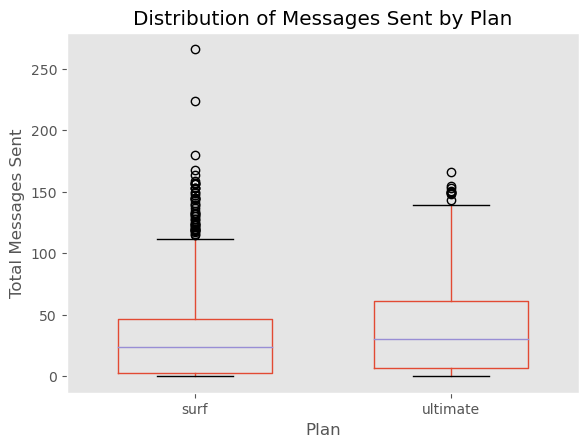

In [44]:
# Plot a boxplot to visualize the distribution of sent messages

final_data.boxplot(column='messages_sent', by='plan', grid=False, widths=0.6)


plt.title('Distribution of Messages Sent by Plan')
plt.xlabel('Plan')
plt.suptitle('')
plt.ylabel('Total Messages Sent')

plt.show()

Conslusions:
1.	**Outliers in Both Plans**: Both Surf and Ultimate have users who send a lot of messages, above 100.
2.	**Similar Median**: The typical number of messages sent is similar for both plans, though Ultimate is slightly higher.
3.	**More Spread in Surf**: Surf users show more variation in the number of messages sent.
4.	**Higher Usage in Ultimate**: The Ultimate plan shows a slightly higher median and upper quartile, meaning typical users send more messages than those on the Surf plan.

Overall conclusions:
1.	**Ultimate Users Send More Messages on Average**: The median number of messages sent is higher for Ultimate users compared to Surf users, indicating that Ultimate users tend to send more messages overall.
2.	**More Variability in Surf**: Surf users show more variation in the number of messages sent, with a wider interquartile range and more outliers (users sending a significantly higher number of messages).
3.	**Outliers in Both Plans**: Both plans have users who send an unusually high number of messages, but Surf has more extreme outliers.


#### Internet

,plan,month,total_mb_used
0,surf,2018-01,4874.860000
1,surf,2018-02,12178.843333
2,surf,2018-03,13345.440000
3,surf,2018-04,11984.203000
4,surf,2018-05,13936.354935
5,surf,2018-06,15301.529175
6,surf,2018-07,16783.600579
7,surf,2018-08,16795.331358
8,surf,2018-09,16591.431289
9,surf,2018-10,17311.335063


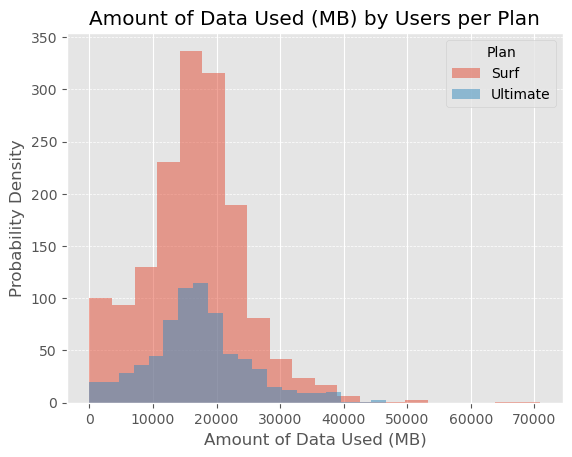

In [45]:
# Compare the amount of internet traffic consumed by users per plan
data_per_plan_per_month = final_data.groupby(['plan', 'month'])['total_mb_used'].mean().reset_index()
display(data_per_plan_per_month)

final_data[final_data['plan'] == 'surf']['total_mb_used'].plot(kind='hist', 
                                                               bins=20, 
                                                               alpha=0.5, 
                                                               label='Surf')

final_data[final_data['plan'] == 'ultimate']['total_mb_used'].plot(kind='hist', 
                                                                   bins=20, 
                                                                   alpha=0.5, 
                                                                   label='Ultimate')

plt.title('Amount of Data Used (MB) by Users per Plan')
plt.xlabel('Amount of Data Used (MB)')
plt.ylabel('Probability Density')

plt.legend(title='Plan')
plt.grid(True, axis='y', linestyle='--', linewidth=0.5)

plt.show()

Conslusions:

1. **Similar Median Usage**: Both plans have similar typical data usage.
2. **More High Users in Ultimate**: Ultimate has more users with high data usage.
3. **Most Users Use 10,000–20,000 MB**: Most users in both plans use between 10,000 and 20,000 MB.
4. **Few Extreme Users in Surf**: Surf has a few users with very high data usage, but fewer than Ultimate.


In [46]:
# Calculate the mean and the variance of the amount of data used
data_usage_mean_var = final_data.groupby(['plan', 'month'])['total_mb_used'].agg(['mean', 'var', 'std']).reset_index()
display(data_usage_mean_var)
print()
display(final_data.groupby(['plan'])['total_mb_used'].agg(['mean', 'var', 'std']).reset_index())

,plan,month,mean,var,std
0,surf,2018-01,4874.860000,1.823995e+07,4270.825963
1,surf,2018-02,12178.843333,4.367296e+07,6608.551952
2,surf,2018-03,13345.440000,6.824556e+07,8261.086946
3,surf,2018-04,11984.203000,5.904494e+07,7684.070578
4,surf,2018-05,13936.354935,6.147653e+07,7840.697302
5,surf,2018-06,15301.529175,4.913339e+07,7009.521342
6,surf,2018-07,16783.600579,6.468655e+07,8042.794778
7,surf,2018-08,16795.331358,7.463649e+07,8639.241188
8,surf,2018-09,16591.431289,5.131665e+07,7163.564029
9,surf,2018-10,17311.335063,6.252794e+07,7907.461081


,plan,mean,var,std
0,surf,16558.283490,6.421640e+07,8013.513327
1,ultimate,17214.699694,6.165229e+07,7851.897435


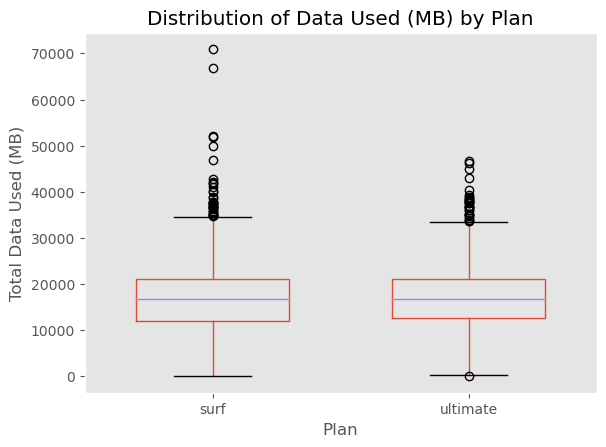

In [47]:
# Plot a boxplot to visualize the distribution of the data usage

final_data.boxplot(column='total_mb_used', by='plan', grid=False, widths=0.6)


plt.title('Distribution of Data Used (MB) by Plan')
plt.xlabel('Plan')
plt.suptitle('')
plt.ylabel('Total Data Used (MB)')

plt.show()

Conslusions:

1. **Similar Median Usage**: The typical data usage is similar for both Surf and Ultimate plans.
2. **More High Users in Ultimate**: Ultimate has more users with high data usage, shown by more outliers.
3. **Wider Range in Ultimate**: Ultimate users have a wider spread of data usage compared to Surf.
4. **Extreme Outliers in Surf**: Surf has a few users with very high data usage, going above 60,000 MB.

Overall conclusions:
1. **Similar Typical Usage**: Both plans have similar typical data usage.
2. **More High Usage in Ultimate**: Ultimate has more users with high data usage.
3. **Wider Range in Ultimate**: Ultimate users show more variation in their data usage.
4. **Extreme Users in Surf**: Surf has fewer high users but some extreme outliers with very high data usage.

### Revenue

To properly analyze the revenue for each plan, we need to first evaluate the user base growth over time.

,plan,month,user_count
0,surf,2018-01,2
1,surf,2018-02,9
2,surf,2018-03,23
3,surf,2018-04,50
4,surf,2018-05,77
5,surf,2018-06,97
6,surf,2018-07,121
7,surf,2018-08,162
8,surf,2018-09,194
9,surf,2018-10,237


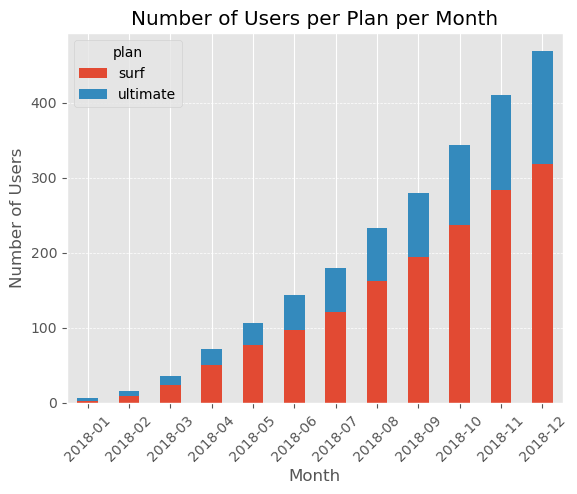

In [48]:
user_count_per_month = final_data.groupby(['plan', 'month'])['user_id'].nunique().reset_index(name='user_count')
display(user_count_per_month)

# Plot the number of users per plan per month

user_count_pivot = user_count_per_month.pivot(index='month', columns='plan', values='user_count')
user_count_pivot.plot(kind='bar', stacked=True)

plt.title('Number of Users per Plan per Month')
plt.xlabel('Month')
plt.ylabel('Number of Users')

plt.grid(True, linestyle='--', linewidth=0.5, axis='y')
plt.xticks(rotation=45)
plt.show()

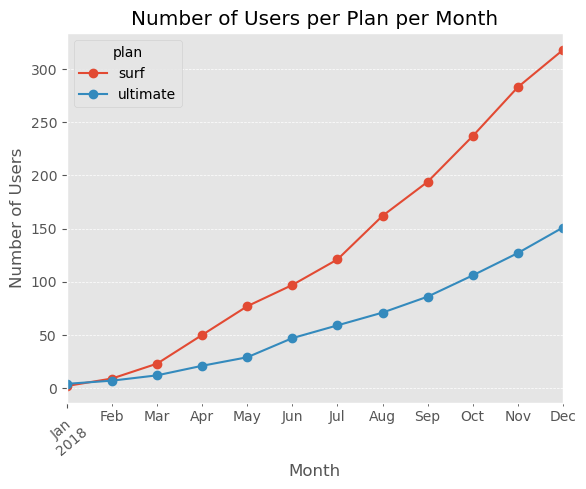

In [49]:
user_count_pivot.plot(kind='line', marker='o')

plt.title('Number of Users per Plan per Month')
plt.xlabel('Month')
plt.ylabel('Number of Users')

plt.grid(True, linestyle='--', linewidth=0.5, axis='y')
plt.xticks(rotation=40)
plt.show()

Conclusions:

**User Growth**:
 * The Surf Plan is much more popular than the Ultimate Plan, with more users joining it each month.
 * By December 2018, the Surf Plan has over 300 users, while the Ultimate Plan has around 150 users.

**Comparison Between Plans**:
 * The Surf Plan grows at a faster rate, attracting more users throughout the year.
 * The Ultimate Plan has a smaller user base and grows more slowly.

**Visual Insights**:
 * The stacked bar plot shows that the Surf Plan consistently dominates the total number of users each month.
 * The line chart highlights that the gap between the number of Surf and Ultimate users widens over time.

**Key Takeaway**:
 * Most users prefer the Surf Plan, while the Ultimate Plan might need adjustments to become more appealing.

,plan,month,sum,mean
0,surf,2018-01,40.00,20.000000
1,surf,2018-02,309.57,34.396667
2,surf,2018-03,1056.65,45.941304
3,surf,2018-04,2035.53,40.710600
4,surf,2018-05,3667.37,47.628182
5,surf,2018-06,4779.80,49.276289
6,surf,2018-07,7583.56,62.674050
7,surf,2018-08,10356.85,63.931173
8,surf,2018-09,11304.67,58.271495
9,surf,2018-10,15504.83,65.421224


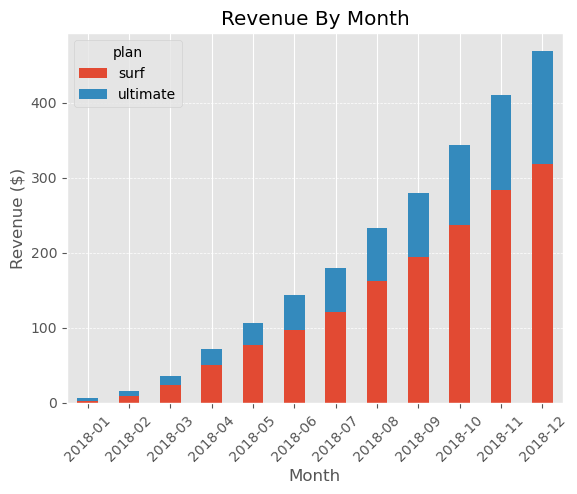

In [50]:
# Calculate total and average monthly revenue for each plan
revenue_per_plan_per_month = final_data.groupby(['plan', 'month'])['monthly_revenue'].agg(['sum', 'mean']).reset_index()
display(revenue_per_plan_per_month)

# Plot total revenue per month for each plan
revenue_pivot = revenue_per_plan_per_month.pivot(index='month', columns='plan', values='sum')
user_count_pivot.plot(kind='bar', stacked=True)

plt.title('Revenue By Month')
plt.xlabel('Month')
plt.ylabel('Revenue ($)')

plt.grid(True, linestyle='--', linewidth=0.5, axis='y')
plt.xticks(rotation=45)
plt.show()

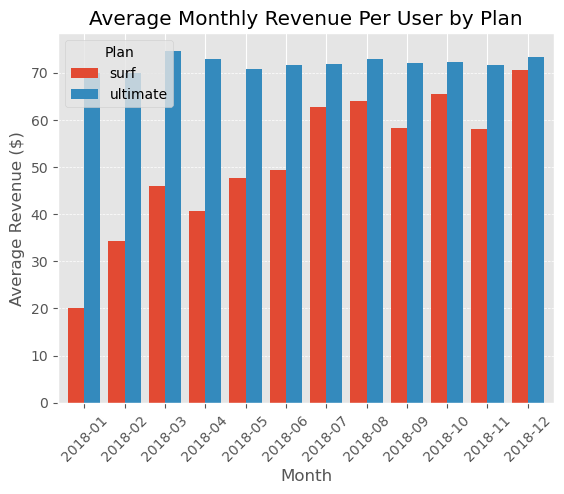

In [51]:
# Plot the average revenue per user per month for each plan
revenue_pivot = revenue_per_plan_per_month.pivot(index='month', columns='plan', values='mean')
revenue_pivot.plot(kind='bar', width=0.8)

plt.title('Average Monthly Revenue Per User by Plan')
plt.xlabel('Month')
plt.ylabel('Average Revenue ($)')

plt.xticks(rotation=45)
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
plt.legend(title='Plan')

plt.show()

Conclusions:
1. **Steady Growth**: Both plans show consistent revenue growth throughout 2018, with Ultimate bringing in more revenue per user due to its higher fee.
2. **Surf Dominates**: Despite Ultimate's higher per-user revenue, Surf generates more total revenue thanks to its much larger user base.
3. **Revenue Gap**: The gap between Surf and Ultimate widens over time, as Surf attracts more users each month.

Takeaway: 
* Surf is more popular, but Ultimate can increase revenue if its user base grows.

### Test statistical hypotheses

1. **Difference in average revenue from users of the Ultimate and Surf calling plans**
- **Null Hypothesis (H₀)**: The average revenue from users of the Ultimate and Surf calling plans is equal.
- **Alternative Hypothesis (H₁)**: The average revenue from users of the Ultimate and Surf calling plans is different.

In [52]:
# Test the hypotheses

surf_revenue = final_data[final_data['plan'] == 'surf']['monthly_revenue']
ultimate_revenue = final_data[final_data['plan'] == 'ultimate']['monthly_revenue']

results = st.ttest_ind(surf_revenue, ultimate_revenue) # Perform independent t-test

print('P-value:', results.pvalue)

alpha = 0.05
if results.pvalue < alpha:
    print("Reject the null hypothesis: There is evidence that the average revenue is different between Surf and Ultimate plans.")
else:
    print("Fail to reject the null hypothesis: No significant difference in average revenue between Surf and Ultimate plans.")


P-value: 2.862674510698644e-08
Reject the null hypothesis: There is evidence that the average revenue is different between Surf and Ultimate plans.


2. **Difference in average revenue from users in the NY-NJ area and the users from the other regions**
- **Null Hypothesis (H₀)**: The average revenue from users in the NY-NJ area is equal to that of users from other regions.
- **Alternative Hypothesis (H₁)**: The average revenue from users in the NY-NJ area is different from that of users from other regions.

In [53]:
# Test the hypotheses

ny_nj_revenue = final_data[final_data['msa'].str.contains('NY-NJ-PA')]['monthly_revenue']
other_regions_revenue = final_data[~final_data['msa'].str.contains('NY-NJ-PA')]['monthly_revenue']

results = st.ttest_ind(ny_nj_revenue, other_regions_revenue) # Perform independent t-test

print('P-value for regions:', results.pvalue)

alpha = 0.05
if results.pvalue < alpha:
    print("Reject the null hypothesis: The average revenue differs between NY-NJ and other regions.")
else:
    print("Fail to reject the null hypothesis: No significant difference in average revenue between NY-NJ and other regions.")


P-value for regions: 0.04355743162134244
Reject the null hypothesis: The average revenue differs between NY-NJ and other regions.


## General conclusion

Key conclusions based on the analysis:

1. **Plan Popularity**:
- The Surf Plan is more popular than the Ultimate Plan, attracting a larger user base throughout the year.
- By the end of the year, the Surf Plan had over 300 users, while the Ultimate Plan had around 150 users.
2. **Revenue Comparison**:
- Despite having fewer users, the Ultimate Plan generates more revenue per user. On average, an Ultimate Plan user brings in around \\$73 per month, compared to \\$66 per month for a Surf Plan user.
- This suggests that the Ultimate Plan is more profitable on a per-user basis.
3. **Regional Differences**:
- There is a significant difference in revenue between users from the NY-NJ area and those from other regions.
- This implies that Megaline may benefit from developing region-specific strategies to maximize revenue.
4. **Usage Patterns**:
- Calls: Both plans show similar call usage patterns, with average call durations between 5 and 7 minutes.
- Messages: Users of the Ultimate Plan send more messages than those on the Surf Plan, likely due to the higher message allowance in the Ultimate Plan.
- Data: Both plans have similar data usage trends, but Ultimate Plan users are more likely to use more data, which aligns with the larger data allowance.
5. **Key Insights**:
- The Surf Plan attracts more users, but the Ultimate Plan is more profitable per user.
- Regional differences in revenue suggest opportunities for location-specific strategies.

**Recommendations**:
- Grow the Ultimate Plan: Focus on increasing subscriptions to the Ultimate Plan to boost revenue.
- Regional Focus: Consider regional strategies for higher revenue in areas like NY-NJ.